In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
from bayes_opt import BayesianOptimization

In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")

In [4]:
X = data[features_num]
y = data[[y_column, 'Source']]

# Adding 2 class columns

In [5]:
def AGN(row):
    
    if row['Classification'] == 'jet-mode radio AGN/low-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'radio-quiet AGN':
        return 1
    elif row['Classification'] == 'star-forming galaxy':
        return 0

In [6]:
# Temporarily relabelling it for function
y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')

/var/lib/condor/execute/dir_1145877/ipykernel_1145953/1941264152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')


## Making subsets

In [7]:
X_elais = X[y['Source']=='Elais-N1']
y_elais = y[y['Source']=='Elais-N1']

X_lockman = X[y['Source']=='Lockman']
y_lockman = y[y['Source']=='Lockman']

X_bootes = X[y['Source']=='Bootes']
y_bootes = y[y['Source']=='Bootes']

## Binary model

In [8]:
def prob_model(model, X, y, problim):
    model.predict_proba()

## Hyperparameter fitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y['AGN'], train_size=0.8, stratify=y[['AGN', 'Source']])

In [ ]:
from bayes_opt import BayesianOptimization

In [1]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta
                    ):
    # The algorithm gives floats, so we round them
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      eta=eta,
                      tree_method='hist',             
                      #gpu_id=0,
                      objective='binary:logistic',
                      eval_metric =['error'],
                      nthread=8,
                      n_estimators=10**5
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                    stratify=y_test_cv, random_state=42)

        # Training the model
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                    eval_set=[
                        (X_val_cv, y_val_cv)
                    ], 
                    early_stopping_rounds=50
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_test_cv)
        y_preds.append(accuracy_score(y_test_cv, y_pred))
    return np.mean(y_preds)

In [2]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (5, 7),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 20),
    'min_child_weight': (0, 10),
    'eta': (0.01, 0.8),
}

In [3]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=8)

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [4]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

NameError: name 'BayesianOptimization' is not defined

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=15,
        n_iter=100,
    )

### Training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y[['AGN', 'Source']], train_size=0.8, stratify=y[['AGN', 'Source']])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test)

In [10]:
agn = y_elais['AGN']
frac = sum(agn==0)/sum(agn)

In [57]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=7,
                     min_child_weight=5,
                     learning_rate=0.2,
                     reg_alpha=5.7,
                     reg_lambda=3.6,
                     tree_method='hist',
                     objective='binary:logistic',
                     eval_metric=['logloss'],
                     #scale_pos_weight=frac,
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [12]:
eval_set = [(X_train, y_train['AGN']), (X_val, y_val['AGN'])]

In [13]:
#eval_set = [(X_lockman, y_lockman['AGN']), (X_bootes, y_bootes['AGN'])]

In [28]:
model.fit(X_train, y_train['AGN'], verbose=True, eval_set=eval_set, early_stopping_rounds=5)

[11:18:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.59229	validation_1-logloss:0.59540
[1]	validation_0-logloss:0.52322	validation_1-logloss:0.52866
[2]	validation_0-logloss:0.47065	validation_1-logloss:0.47804
[3]	validation_0-logloss:0.43217	validation_1-logloss:0.44137
[4]	validation_0-logloss:0.40109	validation_1-logloss:0.41205
[5]	validation_0-logloss:0.37670	validation_1-logloss:0.39004
[6]	validation_0-logloss:0.35606	validation_1-logloss:0.37059
[7]	validation_0-logloss:0.33900	validation_1-logloss:0.35522
[8]	validation_0-logloss:0.32447	validation_1-logloss:0.34269
[9]	validation_0-logloss:0.31324	validation_1-logloss:0.33347
[10]	validation_0-logloss:0.30366	validation_1-logloss:0.32540
[11]	validation_0-logloss:0.29447	validation_1-logloss:0.31760
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              random_state=42, reg_alpha=5.7, reg_lambda=3.6,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [29]:
print(classification_report(model.predict(X_test), y_test['AGN'], digits=4))

              precision    recall  f1-score   support

           0     0.9559    0.9246    0.9400      9368
           1     0.7896    0.8688    0.8273      3049

    accuracy                         0.9109     12417
   macro avg     0.8727    0.8967    0.8836     12417
weighted avg     0.9150    0.9109    0.9123     12417



# Cross-validation

In [58]:
# We need to do a hacky trick so we can stratify over both columns
y['Combined'] = y['AGN'].astype(str) + y['Source'].astype(str)

/var/lib/condor/execute/dir_830810/ipykernel_830932/1983439481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Combined'] = y['AGN'].astype(str) + y['Source'].astype(str)


In [59]:
# Important note here: the splitting is done in such a way that class balance AND source balance is maintained
# See y.value_counts
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Score for each subgroup
scores_subgroups = pd.DataFrame(columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])


n = 16
skf = StratifiedKFold(n_splits=n)

precisions = []
recalls = []
f1s = []
accuracies = []

# Confusion matrices
cm_all = []
cm_Bootes = []
cm_Lockman = []
cm_ElaisN1 = []

# Training history data
training_histories = []

i = 0
# Important note here: the stratified k-fold is done in such a way that class balance AND source balance is maintained
# See y_train.value_counts

# We also need to convert y_train in the split to labels, but that is easily done with a label encoder
for train_index, test_index in skf.split(X_train, y_train['Combined']):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Used for early stopping
    X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                stratify=y_test_cv[['Source', 'AGN']], 
                                                                random_state=42)
    
    eval_set = [(X_train_cv, y_train_cv['AGN']), 
                (X_test_cv, y_test_cv['AGN']),
                (X_val_cv, y_val_cv['AGN'])]
    model.fit(X_train_cv, y_train_cv['AGN'], verbose=False, eval_set=eval_set, early_stopping_rounds=5)
    
    # Model training history
    results = model.evals_result()
    training_histories.append(results)

    y_pred = model.predict(X_test_cv)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_cv['AGN'], y_pred)
    cm_all.append(cm)
    
    # Class-specific scores
    precision = precision_score(y_test_cv['AGN'], y_pred, average=None, labels=[0, 1])
    recall = recall_score(y_test_cv['AGN'], y_pred, average=None, labels=[0, 1])
    f1 = f1_score(y_test_cv['AGN'], y_pred, average=None, labels=[0, 1])
    
    # General scores
    accuracy = accuracy_score(y_test_cv['AGN'], y_pred)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)
    
    """
    # New row for the (non-)detections dataframe, this is essentially a confusion matrix
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == True]
        sub_y_test = y_test_cv[y_test_cv[detection] == True]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['AGN'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    detection_sources = pd.concat([detection_sources, newrow], ignore_index=True)
    
    
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == False]
        sub_y_test = y_test_cv[y_test_cv[detection] == False]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['AGN'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    non_detection_sources = pd.concat([non_detection_sources, newrow], ignore_index=True)
    """
    
    # Scores in subgroups
    for source in ['Bootes', 'Lockman', 'Elais-N1']:      
        # Finding the subgroups
        sub_x_test = X_test_cv[y_test_cv['Source'] == source]
        sub_y_test = y_test_cv[y_test_cv['Source'] == source]
        
        y_pred = model.predict(sub_x_test)
        
        # Confusion matrix
        cm = confusion_matrix(sub_y_test['AGN'], y_pred)
        if source == 'Bootes':
            cm_Bootes.append(cm)
        elif source == 'Lockman':
            cm_Lockman.append(cm)
        elif source == 'Elais-N1':
            cm_ElaisN1.append(cm)
        
        # Class-specific scores
        precision = precision_score(sub_y_test['AGN'], y_pred, average=None, zero_division=0, labels=[0, 1])
        recall = recall_score(sub_y_test['AGN'], y_pred, average=None, zero_division=0, labels=[0, 1])
        f1 = f1_score(sub_y_test['AGN'], y_pred, average=None, zero_division=0, labels=[0, 1])

        # General scores
        accuracy = accuracy_score(sub_y_test['AGN'], y_pred)
        
        # Ratio of sources
        ratio = sub_y_test['AGN'].value_counts()
        
        # appending row to scores dataframe
        data = [[source, accuracy, precision, recall, f1, ratio]]
        newrow = pd.DataFrame(data=data, 
                              columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
        
        scores_subgroups = pd.concat([scores_subgroups, newrow], ignore_index=True)
        
    
    print(f"{(i+1)/n*100}% Done")
    i+=1

6.25% Done
12.5% Done
18.75% Done
25.0% Done
31.25% Done
37.5% Done
43.75% Done
50.0% Done
56.25% Done
62.5% Done
68.75% Done
75.0% Done
81.25% Done
87.5% Done
93.75% Done
100.0% Done


## Training histories

In [ ]:
# Todo, just do one run, it's cleaner that way

## Complete dataset

In [ ]:
labels = ['SFG', 'AGN']

In [74]:
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
accuracies = np.array(accuracies)

In [75]:
precisions_means = np.mean(precisions, axis=0)
precisions_std = np.std(precisions, axis=0)

recalls_means = np.mean(recalls, axis=0)
recalls_std = np.std(recalls, axis=0)

f1s_means = np.mean(f1s, axis=0)
f1s_std = np.std(f1s, axis=0)

In [76]:
for i in [0,1]:
    print(f"{labels[i]}")
    print()
    print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
    print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
    print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
    print("--------------------------------------------------------------")
print(f"Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")

print(f"Macro average precision: {np.mean(precisions)} ± {np.std(precisions)}")
print(f"Macro average recall: {np.mean(recalls)} ± {np.std(recalls)}")
print(f"Macro average F1: {np.mean(f1s)} ± {np.std(f1s)}")

SFG

Precision: 0.9181167241107074 ± 0.005974876807587614
Recall: 0.9547498874815148 ± 0.005256403990462348
F1-score: 0.9360668699287832 ± 0.004926455581150991
--------------------------------------------------------------
AGN

Precision: 0.8630928572853278 ± 0.015214949618803203
Recall: 0.7699853111016922 ± 0.017643979685732385
F1-score: 0.8138149816866145 ± 0.014940676057219262
--------------------------------------------------------------
Accuracy: 0.9048203930412371 ± 0.0073974999829136915
Macro average precision: 0.8906047906980177 ± 0.02984130363252511
Macro average recall: 0.8623675992916034 ± 0.09329500025314627
Macro average F1: 0.8749409258076988 ± 0.062129927792601236


In [78]:
def error_in_sum(stds):
    return np.sqrt(sum(stds**2))

ratio = np.unique(y_train['AGN'], return_counts=True)[1] 
ratio = ratio/sum(ratio)

print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")

Weighted average precision: 0.9032491932288389 ± 0.005992890657315518
Weighted average recall: 0.9048262233755361 ± 0.006119164127191811
Weighted average F1: 0.9030342273924934 ± 0.005405889154396003


## Performance per field

In [79]:
for source in ['Bootes', 'Lockman', 'Elais-N1']:
    # Just selecting the source
    dat = scores_subgroups[scores_subgroups['Source'] == source]
    
    precisions_means = np.mean(dat.Precision.to_numpy(), axis=0)
    precisions_std = np.std(dat.Precision.to_numpy(), axis=0)

    recalls_means = np.mean(dat.Recall.to_numpy(), axis=0)
    recalls_std = np.std(dat.Recall.to_numpy(), axis=0)

    f1s_means = np.mean(dat.F1.to_numpy(), axis=0)
    f1s_std = np.std(dat.F1.to_numpy(), axis=0)
    
    print(source)
    for i in range(2):
        print(f"{labels[i]}")
        print()
        print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
        print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
        print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
        print("--------------------------------------------------------------")
    print(f"Accuracy: {np.mean(dat['Accuracy'])} ± {np.std(dat['Accuracy'])}")

    # I hate storing lists in dataframes
    precisions_grouped = np.array(list(dat.Precision.to_numpy()))
    recalls_grouped = np.array(list(dat.Recall.to_numpy()))
    f1s_grouped = np.array(list(dat.F1.to_numpy()))
    
    # Finding the total ratio by taking the average
    ratio = dat.Ratio.apply(lambda x: x.sort_index())
    ratio = ratio.div(ratio.sum(axis=1), axis=0)
    ratio = ratio.sum(axis=0)/len(ratio)
    
    # For BH we need to ignore the 3rd column, since that doesn't have RQ
    if source != 'BH':
        print(f"Macro average precision: {np.mean(precisions_grouped)} ± {np.std(precisions_grouped)}")
        print(f"Macro average recall: {np.mean(recalls_grouped)} ± {np.std(recalls_grouped)}")
        print(f"Macro average F1: {np.mean(f1s_grouped)} ± {np.std(f1s_grouped)}")

        print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
        print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
        print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")
    else:
        print(f"Macro average precision: {np.mean(precisions_grouped[:,[0,1,3]])} ± {np.std(precisions_grouped[:,[0,1,3]])}")
        print(f"Macro average recall: {np.mean(recalls_grouped[:,[0,1,3]])} ± {np.std(recalls_grouped[:,[0,1,3]])}")
        print(f"Macro average F1: {np.mean(f1s_grouped[:,[0,1,3]])} ± {np.std(f1s_grouped[:,[0,1,3]])}")

        print(f"Weighted average precision: {sum(ratio*precisions_means[[0,1,3]])} ± {error_in_sum(ratio*precisions_std[[0,1,3]])}")
        print(f"Weighted average recall: {sum(ratio*recalls_means[[0,1,3]])} ± {error_in_sum(ratio*recalls_std[[0,1,3]])}")
        print(f"Weighted average F1: {sum(ratio*f1s_means[[0,1,3]])} ± {error_in_sum(ratio*f1s_std[[0,1,3]])}")
    print("------------------------------------------------------------------------------------")

Bootes
SFG

Precision: 0.9083679042416386 ± 0.009793371508236167
Recall: 0.9411654241677561 ± 0.009318942016299785
F1-score: 0.924440136626721 ± 0.007647860622254174
--------------------------------------------------------------
AGN

Precision: 0.8586870060316503 ± 0.02065400015558696
Recall: 0.7896788872891813 ± 0.024382447553302808
F1-score: 0.822546947976364 ± 0.019020947088956467
--------------------------------------------------------------
Accuracy: 0.8940207890502395 ± 0.01087531940034279
Macro average precision: 0.8835274551366444 ± 0.029636073216613306
Macro average recall: 0.8654221557284688 ± 0.07795970708232755
Macro average F1: 0.8734935423015424 ± 0.05296884530989385
Weighted average precision: 0.8929047197391466 ± 0.009317933303575665
Weighted average recall: 0.8940152245176622 ± 0.009939297591053876
Weighted average F1: 0.8927258715385968 ± 0.007924379198488936
------------------------------------------------------------------------------------
Lockman
SFG

Precision: 0

In [30]:
for i in y_test.Source.unique():
    filt = y_test['Source']==i
    
    print(i)
    print(classification_report(model.predict(X_test[filt]), y_test['AGN'][filt], digits=4))
    print('------------------------------------------------------------------')

Lockman
              precision    recall  f1-score   support

           0     0.9527    0.9231    0.9376      3535
           1     0.7933    0.8657    0.8279      1206

    accuracy                         0.9085      4741
   macro avg     0.8730    0.8944    0.8828      4741
weighted avg     0.9122    0.9085    0.9097      4741

------------------------------------------------------------------
Bootes
              precision    recall  f1-score   support

           0     0.9381    0.9088    0.9232      2017
           1     0.7914    0.8523    0.8207       819

    accuracy                         0.8925      2836
   macro avg     0.8647    0.8805    0.8719      2836
weighted avg     0.8957    0.8925    0.8936      2836

------------------------------------------------------------------
Elais-N1
              precision    recall  f1-score   support

           0     0.9682    0.9345    0.9511      3816
           1     0.7839    0.8857    0.8317      1024

    accuracy            

In [31]:
filt

52380    False
8076     False
53212    False
48668    False
48520    False
         ...  
77225    False
54644    False
73859    False
59724    False
10352    False
Name: Source, Length: 12417, dtype: bool

(0.0, 0.6179893000000001)

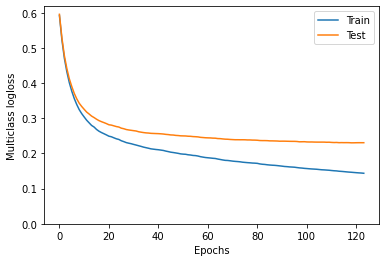

In [32]:
hist = model.evals_result()
plt.plot(hist['validation_0']['logloss'], label='Train')
plt.plot(hist['validation_1']['logloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()
plt.ylim(ymin=0)

# BH

In [8]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better_fixed_fluxes.csv")

In [9]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [10]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification']]

In [11]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [12]:
# Changing column order
Best_Heckman_X = Best_Heckman_X[features_num]

In [13]:
Best_Heckman_y['AGN'] =  Best_Heckman_y.apply(AGN, axis=1, result_type='expand')

/var/lib/condor/execute/dir_1145877/ipykernel_1145953/4091958156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['AGN'] =  Best_Heckman_y.apply(AGN, axis=1, result_type='expand')


# SHAP

In [196]:
import shap
shap.initjs()

In [199]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

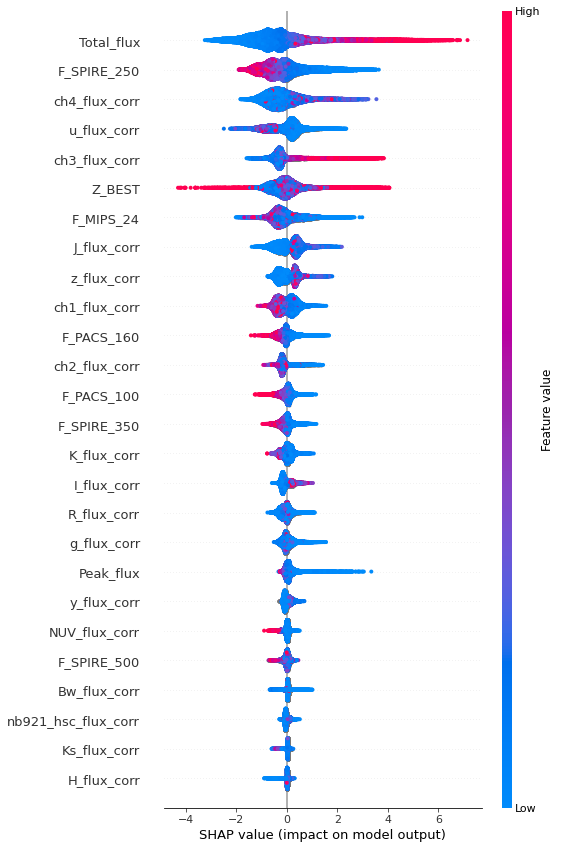

In [212]:
shap.summary_plot(shap_values, X_train, max_display=999)

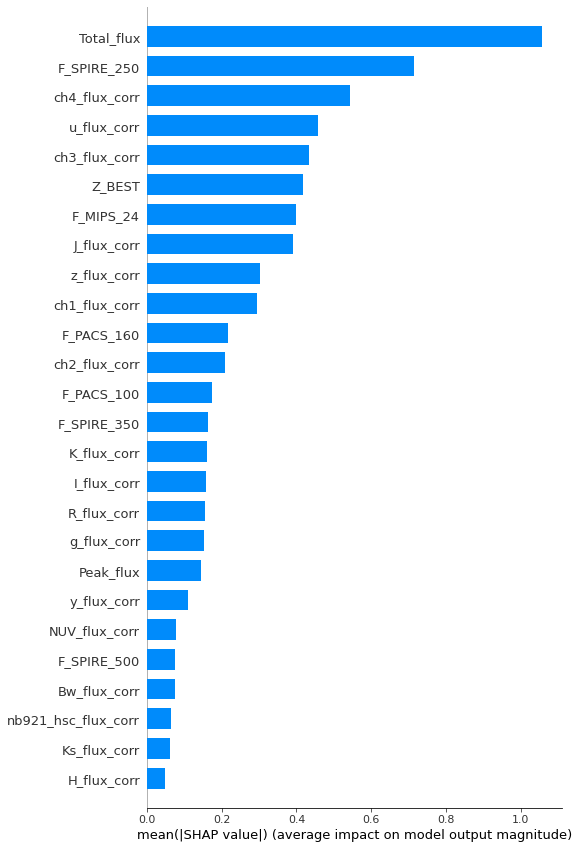

In [251]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=999)

In [271]:
mean_shap = np.abs(shap_values).mean(axis=0)
tot_mean_shap = sum(mean_shap)

# Sorting columns by shap value
columns = [x for _, x in sorted(zip(mean_shap, X_train.columns), reverse=True)]
sorted_mean_shap = sorted(mean_shap, reverse=True)
sorted_frac_shap = sorted_mean_shap/tot_mean_shap

for i in range(len(columns)):
    print(columns[i], ':', sorted_frac_shap.cumsum()[i])

Total_flux : 0.14976415
F_SPIRE_250 : 0.25090897
ch4_flux_corr : 0.32776603
u_flux_corr : 0.3925236
ch3_flux_corr : 0.45403865
Z_BEST : 0.5132486
F_MIPS_24 : 0.56989187
J_flux_corr : 0.62535614
z_flux_corr : 0.6683332
ch1_flux_corr : 0.7101288
F_PACS_160 : 0.74093103
ch2_flux_corr : 0.7706696
F_PACS_100 : 0.7951227
F_SPIRE_350 : 0.81835824
K_flux_corr : 0.8409105
I_flux_corr : 0.8633893
R_flux_corr : 0.8853561
g_flux_corr : 0.90709174
Peak_flux : 0.9273957
y_flux_corr : 0.94273406
NUV_flux_corr : 0.9538754
F_SPIRE_500 : 0.9645663
Bw_flux_corr : 0.97519815
nb921_hsc_flux_corr : 0.9843681
Ks_flux_corr : 0.9931021
H_flux_corr : 1.0


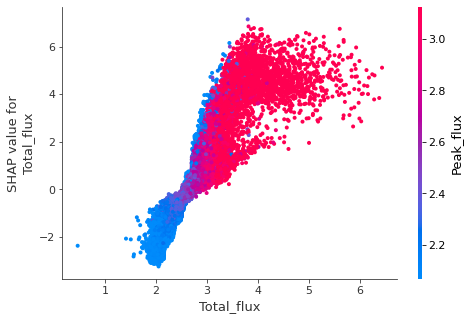

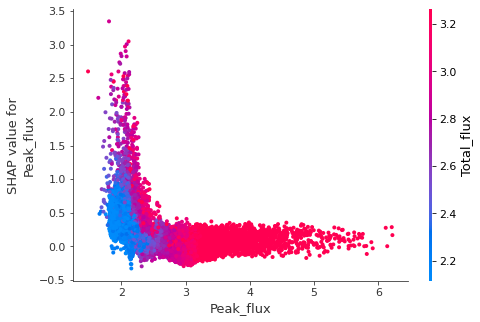

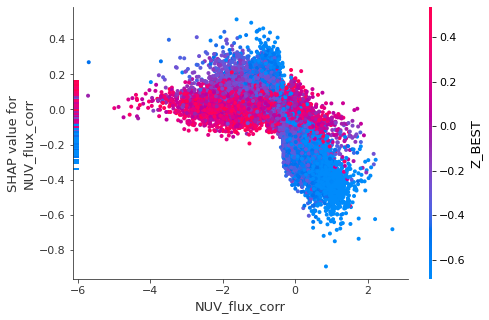

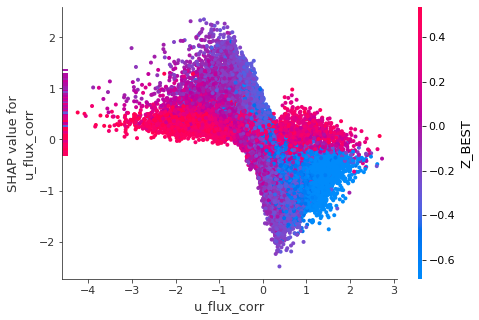

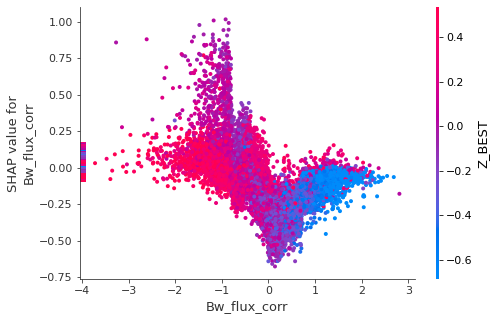

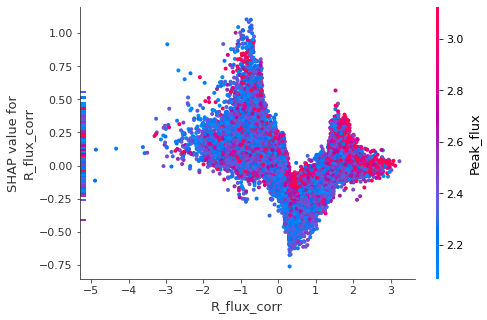

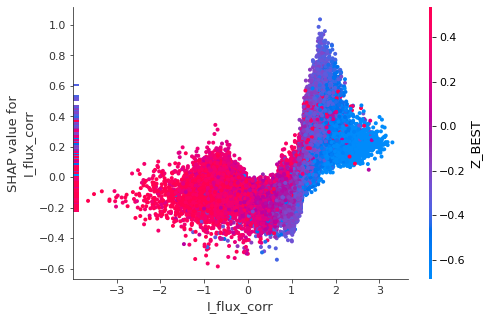

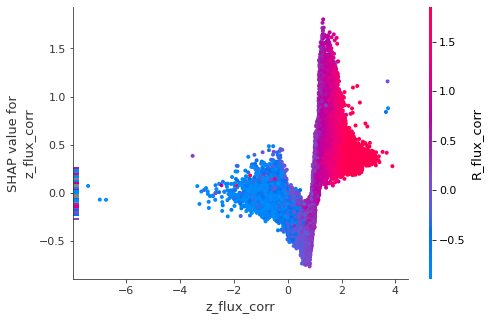

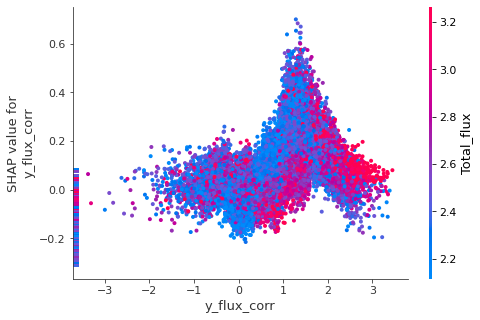

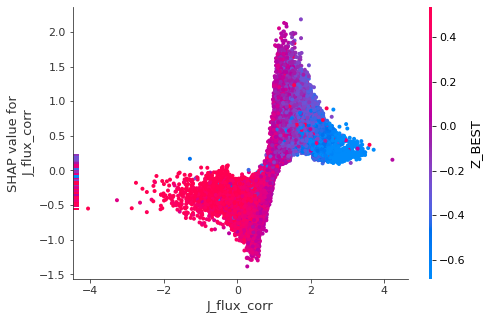

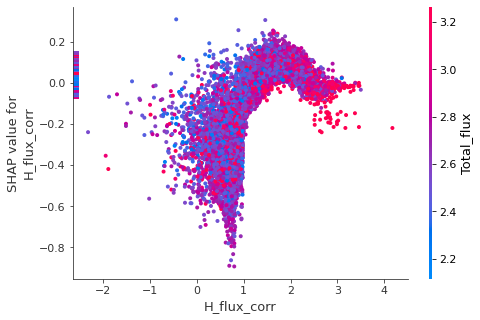

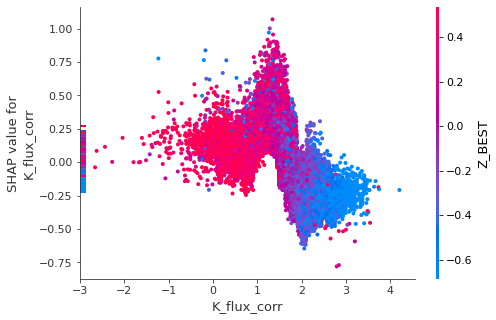

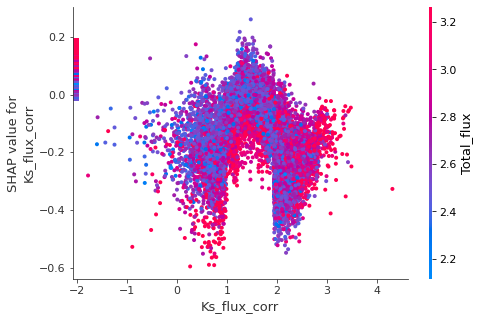

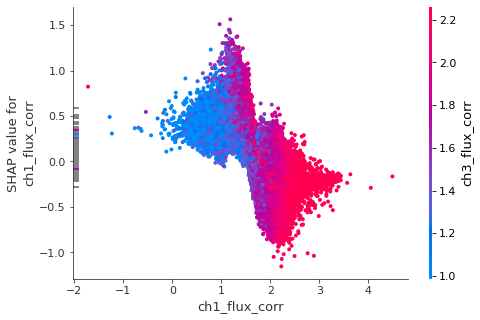

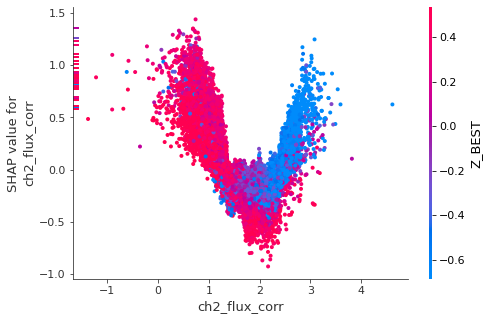

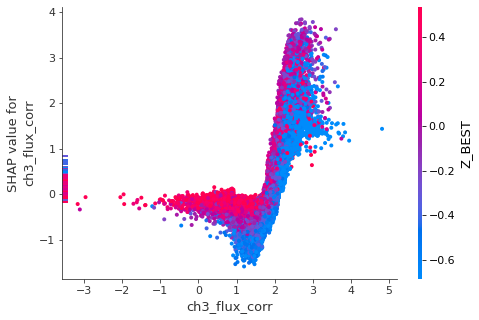

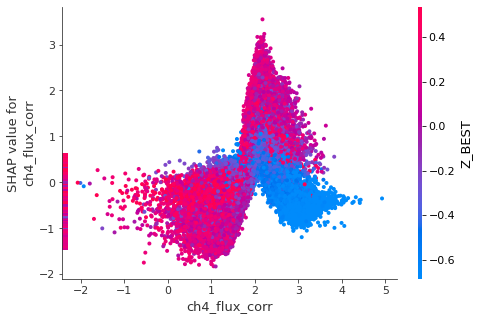

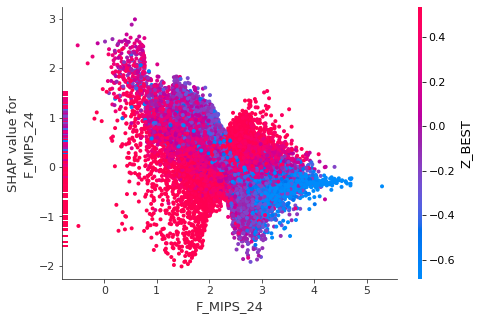

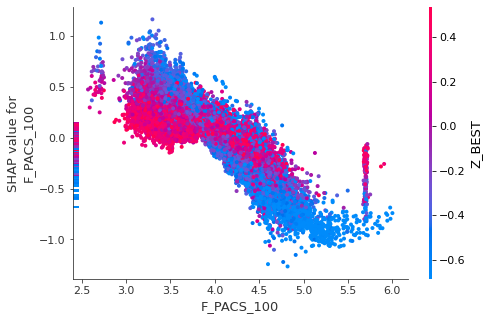

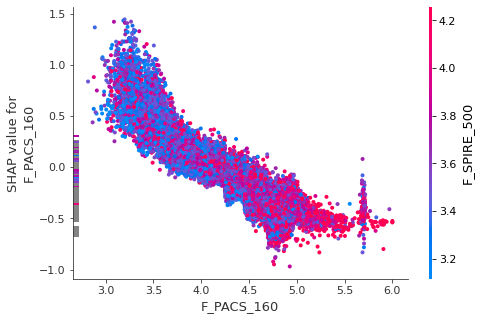

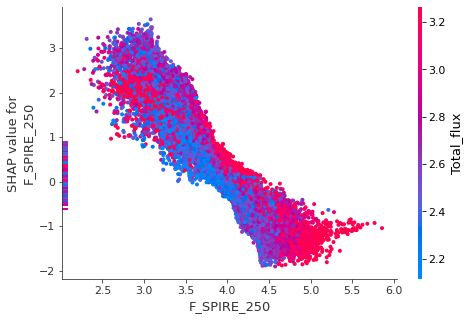

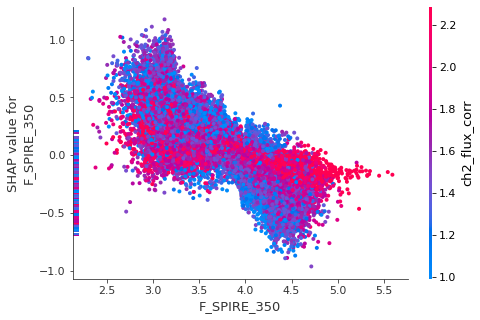

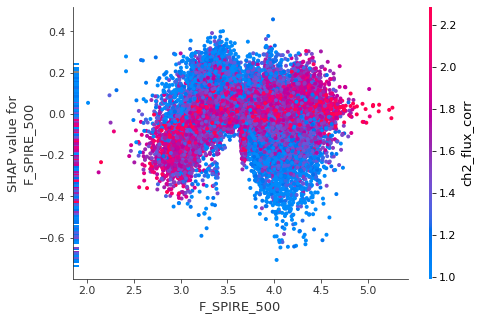

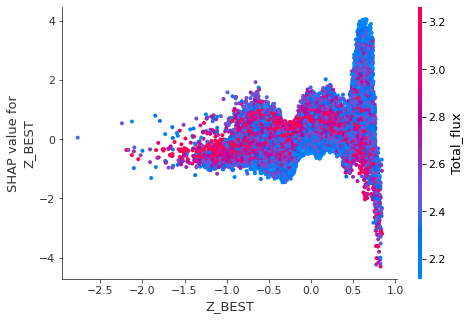

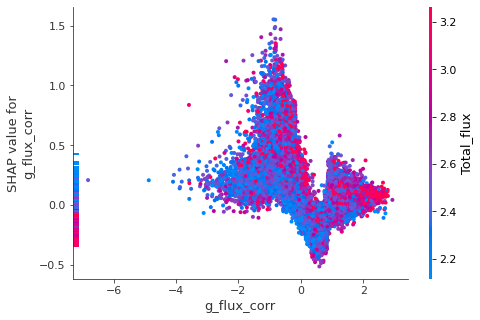

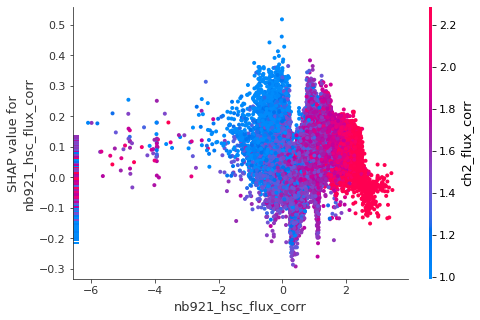

In [205]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, np.log10(X_train), display_features=X_train)

Text(27.362256944444447, 0.5, 'ch4_flux_corr/ch2_flux_corr')

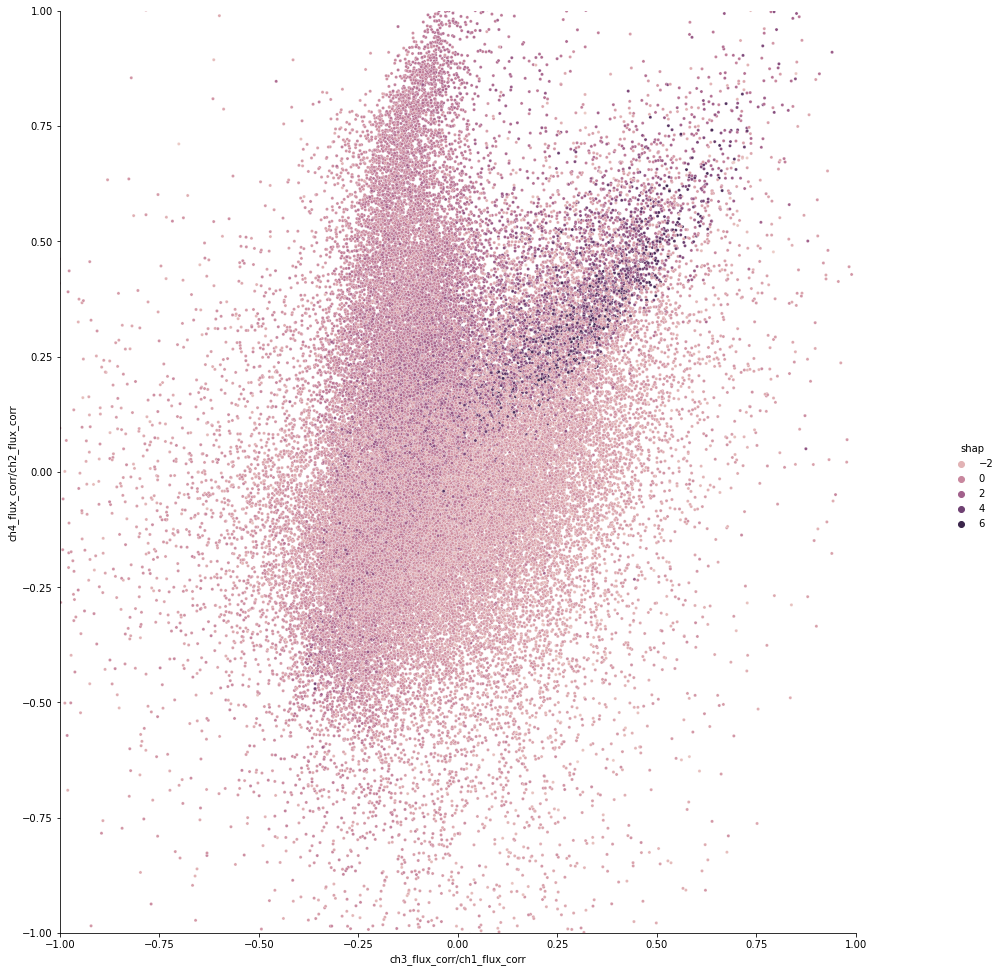

In [249]:
plot_data = pd.DataFrame(columns=['x', 'y', 'shap'])


x_0 = 15
x_1 = 13

y_0 = 16
y_1 = 14

plot_data['x'] = np.log10(X_train[X_train.columns[x_0]]/X_train[X_train.columns[x_1]])
plot_data['y'] = np.log10(X_train[X_train.columns[y_0]]/X_train[X_train.columns[y_1]])
plot_data['shap'] = shap_values[:,x_0] - shap_values[:,x_1] + shap_values[:,y_0] - shap_values[:,y_1]

s = sns.relplot(data=plot_data, x='x', y='y', hue='shap', s=10)

s.fig.set_figwidth(15)
s.fig.set_figheight(15)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f'{X_train.columns[x_0]}/{X_train.columns[x_1]}')
plt.ylabel(f'{X_train.columns[y_0]}/{X_train.columns[y_1]}')

## Other limit instead of 50%

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score


probs = model.predict_proba(X_test)

# Limit of probability
lim = []
accuracy = []
f1_macro = []
balanced_accuracy = []

agn_count = []
sfg_count = []

for i in np.arange(0.5,0.96,0.01):
    i = round(i,2)
    
    lim.append(i)
    
    filt = (probs>i).sum(axis=1).astype(bool)
    
    accuracy.append(accuracy_score(model.predict(X_test[filt]), y_test['AGN'][filt]))
    f1_macro.append(f1_score(y_test['AGN'][filt], model.predict(X_test[filt]), average='macro'))
    balanced_accuracy.append(balanced_accuracy_score(y_test['AGN'][filt], model.predict(X_test[filt])))
    
    agn_count.append(sum(y_test['AGN'][filt]))
    sfg_count.append(len(y_test['AGN'][filt]) - sum(y_test['AGN'][filt]))

In [36]:
agn_count = np.array(agn_count)
sfg_count = np.array(sfg_count)

all_agn_count = sum(y_test['AGN'])
all_sfg_count = len(y_test['AGN']) - sum(y_test['AGN'])
all_count = len(y_test['AGN'])

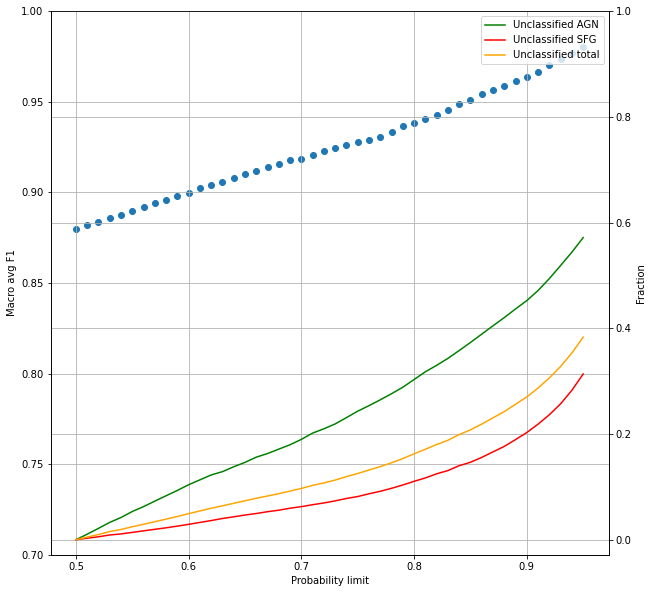

In [34]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(lim, f1_macro)
ax1.set_xlabel("Probability limit")
ax1.set_ylabel("Macro avg F1")
ax1.set_ylim(0.7,1)
ax1.grid()

# Counts
ax2 = ax1.twinx()
ax2.plot(lim, (all_agn_count-agn_count)/all_agn_count, color='g', label='Unclassified AGN')
ax2.plot(lim, (all_sfg_count-sfg_count)/all_sfg_count, color='r', label='Unclassified SFG')
ax2.plot(lim, (all_count-agn_count-sfg_count)/all_count, color='orange', label='Unclassified total')
ax2.set_ylim(ymax=1)
ax2.set_ylabel("Fraction")
ax2.legend()
ax2.grid()

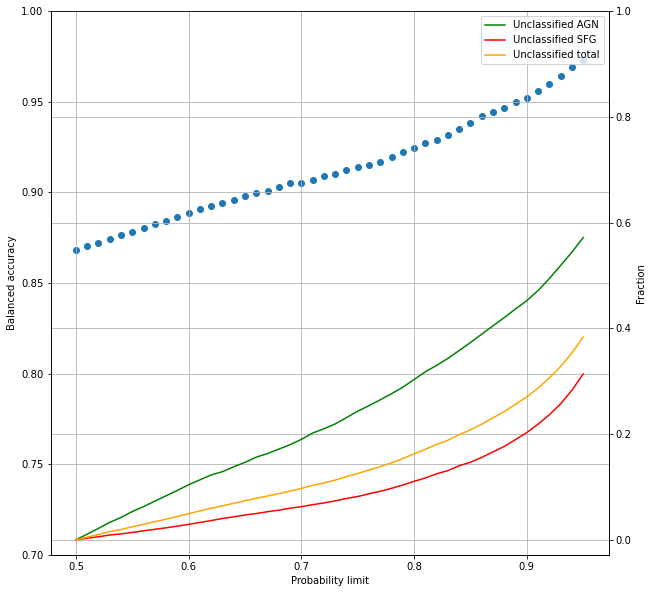

In [37]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(lim, balanced_accuracy)
ax1.set_xlabel("Probability limit")
ax1.set_ylabel("Balanced accuracy")
ax1.set_ylim(0.7,1)
ax1.grid()

# Counts
ax2 = ax1.twinx()
ax2.plot(lim, (all_agn_count-agn_count)/all_agn_count, color='g', label='Unclassified AGN')
ax2.plot(lim, (all_sfg_count-sfg_count)/all_sfg_count, color='r', label='Unclassified SFG')
ax2.plot(lim, (all_count-agn_count-sfg_count)/all_count, color='orange', label='Unclassified total')
ax2.set_ylim(ymax=1)
ax2.set_ylabel("Fraction")
ax2.legend()
ax2.grid()

## Relation between probability of XGBoost vs actual probablity

In [83]:
acc_predicted = []
acc_actual = []

delta_z = 0.1
for z in np.arange(0,5,delta_z):
    z = round(z,2)
    X_bin = X_test[(X_test.Z_BEST>z) & ((X_test.Z_BEST<(z+delta_z)))]
    y_bin = y_test[(X_test.Z_BEST>z) & ((X_test.Z_BEST<(z+delta_z)))]
    
    # Selectin correct predictions
    prob = model.predict_proba(X_bin)[range(len(X_bin)),y_bin].mean()
    acc_predicted.append(prob)

    acc_actual.append(accuracy_score(model.predict(X_bin), y_bin))

Text(0, 0.5, 'Actual accuracy')

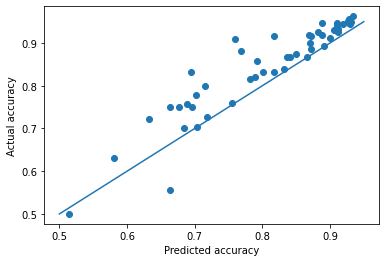

In [85]:
plt.scatter(acc_predicted, acc_actual)
plt.plot([0.5,0.95], [0.5,0.95])
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
#plt.xlim(0,1)
#plt.ylim(0,1)

# BH

In [14]:
X_combined = pd.concat([X_lockman, X_elais])
y_combined = pd.concat([y_lockman, y_elais])

In [15]:
from flaml import AutoML
automl = AutoML()

In [242]:
y_bootes['AGN']

0        0
1        1
2        0
3        0
4        1
        ..
17724    0
17725    1
17726    0
17727    0
17728    0
Name: AGN, Length: 17729, dtype: int64

In [29]:
data

,Source_Name,RA,DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,EBV,FUV_flux_corr,...,g_hsc_flux_corr,g_hsc_fluxerr_corr,r_hsc_fluxerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,ap_to_model_err_g,ap_to_model_err_r,g_rcs_flux_corr,g_rcs_fluxerr_corr,r_rcs_fluxerr_corr
0,ILTJ142426.44+354503.4,216.110147,35.750944,841.504227,0.000153,504.067340,0.000061,S,0.013406,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ILTJ142426.73+341313.2,216.111396,34.220345,1497.581978,0.000151,934.846936,0.000063,S,0.015971,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ILTJ142426.85+352815.2,216.111868,35.470915,502.877076,0.000131,322.345615,0.000056,S,0.015259,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ILTJ142427.17+354647.0,216.113189,35.779745,300.955344,0.000093,329.597236,0.000057,S,0.012972,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ILTJ142427.57+352154.3,216.114868,35.365108,285.588580,0.000080,318.506481,0.000049,S,0.019374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77604,ILTJ110429.21+574608.2,166.121696,57.768955,404.272879,0.000089,344.389065,0.000046,S,0.006608,0.341273,...,0.609437,0.084647,0.166526,NaN,NaN,NaN,0.232637,NaN,NaN,NaN
77605,ILTJ110431.18+574607.3,166.129929,57.768697,1480.551760,0.000115,936.415793,0.000048,M,0.006676,0.262419,...,0.949995,0.085010,0.161736,NaN,NaN,0.327651,0.202050,NaN,NaN,NaN
77606,ILTJ110431.77+574619.9,166.132368,57.772218,709.620314,0.000131,374.982368,0.000048,M,0.006691,0.329990,...,1.320066,0.085998,0.163132,NaN,NaN,0.199074,0.147825,NaN,NaN,NaN
77607,ILTJ110435.97+575043.3,166.149887,57.845374,591.226106,0.000112,497.437861,0.000048,M,0.007079,0.561018,...,1.528544,0.084836,0.161442,NaN,NaN,0.144919,0.064418,NaN,NaN,NaN


In [254]:
import warnings

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_combined, y_combined['AGN'], task="regression", metric='r2',
                                X_val=X_bootes , y_val=y_bootes['AGN'],
                                #ensemble=True,
                                estimator_list=['lgbm'], 
                                time_budget=3600, n_jobs=8,
                                #eval_method='cv',
                                log_file_name='general.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 02-24 14:22:07] {2390} INFO - task = regression
INFO:flaml.automl:task = regression
[flaml.automl: 02-24 14:22:07] {2392} INFO - Data split method: uniform
INFO:flaml.automl:Data split method: uniform
[flaml.automl: 02-24 14:22:07] {2396} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 02-24 14:22:07] {2465} INFO - Minimizing error metric: 1-r2
INFO:flaml.automl:Minimizing error metric: 1-r2
[flaml.automl: 02-24 14:22:07] {2605} INFO - List of ML learners in AutoML Run: ['lgbm']
INFO:flaml.automl:List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-24 14:22:07] {2897} INFO - iteration 0, current learner lgbm
INFO:flaml.automl:iteration 0, current learner lgbm
[flaml.automl: 02-24 14:22:07] {3025} INFO - Estimated sufficient time budget=13631s. Estimated necessary time budget=14s.
INFO:flaml.automl:Estimated sufficient time budget=13631s. Estimated necessary time budget=14s.
[flaml.automl: 02-24 14:22:07] {3072} INFO 

INFO:flaml.automl:iteration 20, current learner lgbm
[flaml.automl: 02-24 14:23:16] {3072} INFO -  at 69.2s,	estimator lgbm's best error=0.4770,	best estimator lgbm's best error=0.4770
INFO:flaml.automl: at 69.2s,	estimator lgbm's best error=0.4770,	best estimator lgbm's best error=0.4770
[flaml.automl: 02-24 14:23:16] {2897} INFO - iteration 21, current learner lgbm
INFO:flaml.automl:iteration 21, current learner lgbm
[flaml.automl: 02-24 14:23:19] {3072} INFO -  at 72.1s,	estimator lgbm's best error=0.4770,	best estimator lgbm's best error=0.4770
INFO:flaml.automl: at 72.1s,	estimator lgbm's best error=0.4770,	best estimator lgbm's best error=0.4770
[flaml.automl: 02-24 14:23:19] {2897} INFO - iteration 22, current learner lgbm
INFO:flaml.automl:iteration 22, current learner lgbm
[flaml.automl: 02-24 14:23:22] {3072} INFO -  at 75.6s,	estimator lgbm's best error=0.4770,	best estimator lgbm's best error=0.4770
INFO:flaml.automl: at 75.6s,	estimator lgbm's best error=0.4770,	best estim

In [255]:
pred = automl.predict(Best_Heckman_X)
pred = np.rint(pred)
print(classification_report(pred, Best_Heckman_y['AGN'], digits=4))

              precision    recall  f1-score   support

         0.0     0.4161    0.3404    0.3744      3561
         1.0     0.7708    0.8228    0.7960      9601

    accuracy                         0.6923     13162
   macro avg     0.5934    0.5816    0.5852     13162
weighted avg     0.6748    0.6923    0.6819     13162



In [245]:
pred = automl.predict(Best_Heckman_X)
pred.max()

0.9164172724254431

In [18]:
import lightgbm as lgb

In [19]:
param = {
    #'n_estimators': 189,
    'n_estimators': 10**5,
  'num_leaves': 20,
  'min_child_samples': 6,
  'learning_rate': 0.06500463168967072,
  'log_max_bin': 10,
  'colsample_bytree': 0.6649148062238498,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 0.004681547467007761}

In [20]:
train_data = lgb.Dataset(X_combined, label=y_combined['AGN'])
validation_data = lgb.Dataset(X_bootes, label=y_bootes['AGN'])

In [21]:
bst = lgb.train(param, train_data, valid_sets=[validation_data], early_stopping_rounds=20)

/Users/users/karsten/.local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/users/karsten/.local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 59880, number of used features: 23
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Start training from score 0.258066
[1]	valid_0's l2: 0.206177
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.196376
[3]	valid_0's l2: 0.187074
[4]	valid_0's l2: 0.18071
[5]	valid_0's l2: 0.174203
[6]	valid_0's l2: 0.167528
[7]	valid_0's l2: 0.162764
[8]	valid_0's l2: 0.158223
[9]	valid_0's l2: 0.153657
[10]	valid_0's l2: 0.148977
[11]	valid_0's l2: 0.146476
[12]	valid_0's l2: 0.14297
[13]	valid_0's l2: 0.140383
[14]	valid_0's l2: 0.137662
[15]	valid_0's l2: 0.135448
[16]	valid_0's l2: 0.133371
[

In [22]:
pred = bst.predict(Best_Heckman_X)
#pred = (pred-pred.min())
#pred = pred/pred.max()
pred = np.rint(pred)
print(classification_report(pred, Best_Heckman_y['AGN'], digits=4))

              precision    recall  f1-score   support

         0.0     0.5043    0.8443    0.6314      1740
         1.0     0.9736    0.8736    0.9209     11422

    accuracy                         0.8697     13162
   macro avg     0.7389    0.8589    0.7761     13162
weighted avg     0.9115    0.8697    0.8826     13162



In [23]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")

In [24]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [25]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification']]

In [26]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [27]:
mightee_y['AGN'] =  mightee_y.apply(AGN, axis=1, result_type='expand')

/var/lib/condor/execute/dir_1145877/ipykernel_1145953/2572876279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['AGN'] =  mightee_y.apply(AGN, axis=1, result_type='expand')


In [28]:
pred = bst.predict(mightee_X)
#pred = (pred-pred.min())
#pred = pred/pred.max()
pred = np.rint(pred)
print(classification_report(pred, mightee_y['AGN'], digits=4))

              precision    recall  f1-score   support

         0.0     0.7900    0.7843    0.7871      2810
         1.0     0.6165    0.6244    0.6204      1560

    accuracy                         0.7272      4370
   macro avg     0.7032    0.7044    0.7038      4370
weighted avg     0.7280    0.7272    0.7276      4370

